## Audio Files -> Spectrograms (to feed it later to a CNN model)

### How does the Spectrogram look? (Testing with one file)

Digit Spoken - 6, Person 47, Sex - Female


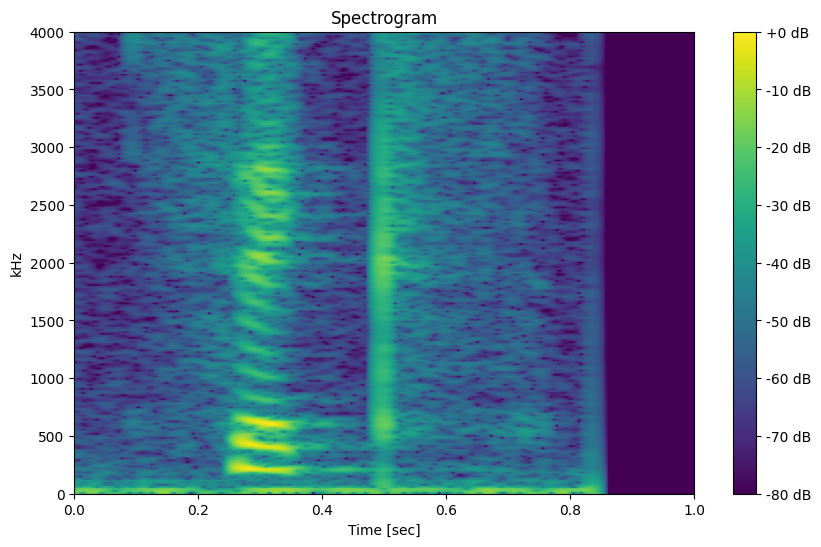

In [3]:
import os
import json
import numpy as np
import scipy.signal
import librosa
import h5py
import random
import time
from scipy.io import wavfile as wavf
import matplotlib.pyplot as plt



filepath = "/kaggle/input/audiomnist/data/47/6_47_0.wav"
# Extract meta information from records
digit, person_number, repetition = filepath.rstrip(".wav").split("/")[-1].split("_")
# Speaker 47 is female
print(f"Digit Spoken - {digit}, Person {person_number}, Sex - Female")

# read data
sample_rate, data = wavf.read(filepath)
# print(sample_rate, data)

# resample
data = librosa.core.resample(y=data.astype(np.float32), orig_sr=sample_rate, target_sr=8000, res_type="scipy")

# Make length 8000
# zero padding
if len(data) > 8000:
    raise ValueError("data length cannot exceed padding length.")
elif len(data) < 8000:
    embedded_data = np.zeros(8000)
    offset = np.random.randint(low = 0, high = 8000 - len(data))
    embedded_data[offset:offset+len(data)] = data
elif len(data) == 8000:
    # nothing to do here
    embedded_data = data
    pass
# stft, with seleced parameters, spectrogram will have shape (228,230)
f, t, Zxx = scipy.signal.stft(embedded_data, 8000, nperseg = 455, noverlap = 420, window='hann')
# get amplitude (Crop to size 227*227 by discarding highest frequency bin and last 3 time segments)
Zxx = np.abs(Zxx[0:227, 2:-1])
Zxx = np.atleast_3d(Zxx).transpose(2,0,1)
# convert to decibel
Zxx = librosa.amplitude_to_db(Zxx, ref = np.max)
frequencies = np.linspace(0, 8000 // 2, Zxx.shape[1])
times = np.linspace(0, 1, Zxx.shape[2])

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(Zxx[0], aspect='auto', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()], origin='lower')
plt.ylabel('kHz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time [sec]')
# plt.gca().invert_yaxis()
plt.show()

### Converting all audio files to Spectrogram and saving it in HDF5 file format
### 60 total Speakers (48M, 12F) -> Selecting 12 female and 12 random male for Sex Classification (to keep equal contribution)

In [4]:
import os
import json
import numpy as np
import scipy.signal
import librosa
import h5py
import random
import time
from scipy.io import wavfile as wavf
from tqdm import tqdm


metaData = json.load(open("/kaggle/input/audiomnist/data/audioMNIST_meta.txt"))

data_dir = "/kaggle/input/audiomnist/data"
target_sr = 8000  # Target sampling rate
n_samples = 8000  # Number of samples to ensure in the audio signal

# Initialize speaker lists based on gender
male_speakers = [speaker for speaker, info in metaData.items() if info["gender"] == "male"]
female_speakers = [speaker for speaker, info in metaData.items() if info["gender"] == "female"]

# Choose 12 male speakers randomly
selected_male_speakers = random.sample(male_speakers, 12)

num_train = int(0.7 * 12)  # 70% of 12 = 8.4, keeping 8
num_val = int(0.15 * 12) + 1  # 15% of 12 = 1.8, keeping 2

# Split male and female speakers
train_speakers = selected_male_speakers[:num_train] + female_speakers[:num_train]
val_speakers = selected_male_speakers[num_train:num_train+num_val] + female_speakers[num_train:num_train+num_val]
test_speakers = selected_male_speakers[num_train+num_val:] + female_speakers[num_train+num_val:]

# Initialize HDF5 file
hdf5_path = 'processed_data.hdf5'
with h5py.File(hdf5_path, 'w') as hdf5_file:
    # Create groups for train, validation, and test
    train_group = hdf5_file.create_group('train')
    val_group = hdf5_file.create_group('validation')
    test_group = hdf5_file.create_group('test')
    # Iterate over folders and files
    for speaker_folder in tqdm(sorted(os.listdir(data_dir))):
        if speaker_folder in train_speakers:
            target_group = train_group
        elif speaker_folder in val_speakers:
            target_group = val_group
        elif speaker_folder in test_speakers:
            target_group = test_group
        else:
            continue
        speaker_path = os.path.join(data_dir, speaker_folder)
        if os.path.isdir(speaker_path):
            for filename in os.listdir(speaker_path):
                filepath = os.path.join(speaker_path, filename)
                # Extract meta information
                digit, person_number, repetition = filepath.rstrip(".wav").split("/")[-1].split("_")
                
                # Read data
                sample_rate, data = wavf.read(filepath)
                
                # Resample
                data = librosa.core.resample(y=data.astype(np.float32), orig_sr=sample_rate, target_sr=target_sr, res_type="scipy")
                
                # Padding
                if len(data) > n_samples:
                    raise ValueError("Data length cannot exceed padding length.")
                elif len(data) < n_samples:
                    embedded_data = np.zeros(n_samples)
                    offset = np.random.randint(low=0, high=n_samples - len(data))
                    embedded_data[offset:offset+len(data)] = data
                else:
                    embedded_data = data
                
                # Compute STFT and convert to dB according to the paper
                f, t, Zxx = scipy.signal.stft(embedded_data, target_sr, nperseg=455, noverlap=420, window='hann')
                Zxx = np.abs(Zxx[0:227, 2:-1])
                Zxx = np.atleast_3d(Zxx).transpose(2,0,1)
                Zxx = librosa.amplitude_to_db(Zxx, ref=np.max)
                
                # Create dataset
                dataset_name = f"{digit}_{person_number}_{repetition}"
                target_group.create_dataset(dataset_name, data=Zxx, compression="gzip")
                # STORING 2 TYPES OF INFO FOR CLASSIFICATION TASKS LATER - DIGIT SPOKEN AND SEX
                target_group[dataset_name].attrs['label'] = np.array([[int(digit), 0 if metaData[person_number]["gender"] == "male" else 1]])

print("Processing complete. Data stored in HDF5 format.")

100%|██████████| 61/61 [04:44<00:00,  4.66s/it]

Processing complete. Data stored in HDF5 format.


## AlexNet Model Implementation

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2)
        
        # Pooling Layer (Defining 3 different because LRP from Captum requires unique pooling layer names)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # Fully connected layers
        self.fc6 = nn.Linear(256 * 6 * 6, 1024)  # Size needs to be adjusted based on the output of conv5
        self.fc7 = nn.Linear(1024, 1024)
        self.fc8 = nn.Linear(1024, num_classes)
        
        # Dropout layers
        self.dropout = nn.Dropout(0.5)
        self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers + ReLU + Pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool3(F.relu(self.conv5(x)))
        
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers + ReLU + Dropout
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout1(x)
        x = self.fc8(x)
        
        return x

## Create a Dataset class to read HDF5 file

In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader
import h5py
import numpy as np
from tqdm import tqdm

# Custom Dataset Class
class AudioMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, hdf5_path, split='train', modelType="Sex"):
        self.hdf5_path = hdf5_path
        self.split = split
        self.modelType = modelType
        with h5py.File(self.hdf5_path, 'r') as f:
            self.keys = list(f[split].keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_path, 'r') as f:
            group = f[self.split]
            dataset = group[self.keys[idx]]
            spectrogram = np.array(dataset)
            if (self.modelType == "Sex"):
                label = dataset.attrs['label'][0,1]
            elif (self.modelType == "Digit"):
                label = dataset.attrs['label'][0,0]
        return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

## Train the model for Sex Classification

Using device: cuda


100%|██████████| 250/250 [00:37<00:00,  6.61it/s]


Epoch 1, Loss: 0.2624, Val Accuracy: 87.45%


100%|██████████| 250/250 [00:36<00:00,  6.84it/s]


Epoch 2, Loss: 0.0291, Val Accuracy: 97.60%


100%|██████████| 250/250 [00:36<00:00,  6.90it/s]


Epoch 3, Loss: 0.0097, Val Accuracy: 96.05%


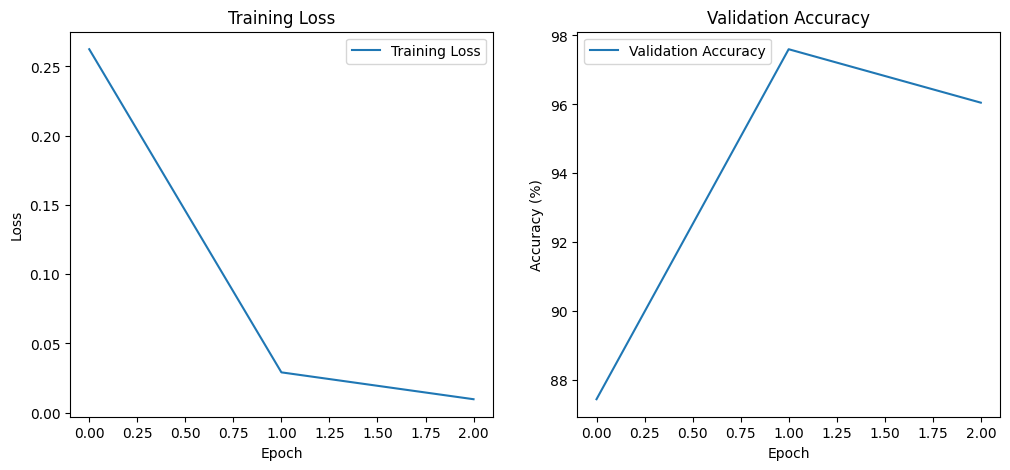

In [11]:
# Prepare Datasets and Loaders
hdf5_path = 'processed_data.hdf5'

np.random.seed(42)

train_dataset = AudioMNISTDataset(hdf5_path, 'train')
val_dataset = AudioMNISTDataset(hdf5_path, 'validation')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_epochs = 3

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model, Loss, and Optimizer
model = AlexNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training and Validation
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to the selected device
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
#     scheduler.step()  # Update the learning rate
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)  # Move data to the selected device
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

## Accuracy on test set

In [13]:
from sklearn.metrics import classification_report, accuracy_score
import torch

test_dataset = AudioMNISTDataset(hdf5_path, 'test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model.eval()  # Set the model to evaluation mode

true_labels = []
predicted_labels = []

with torch.no_grad():  # No need to track gradients
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print(classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(2)]))


Test Accuracy: 97.70%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [15]:
!pip install captum

In [16]:
# Ensure the model is on the correct device and in evaluation mode
model = model.to(device).eval()

# Extract a single batch from the test_loader
data, target = next(iter(test_loader))

# Move the batch to the same device as your model
data, target = data.to(device), target.to(device)

In [21]:
# Select the first 2 examples in the batch for analysis
test_data_point = data[0].unsqueeze(0)  # Add batch dimension
test_target_point = target[0].item()  # Get the label as an integer

# Select the first example in the batch for analysis
test_data_point1 = data[2].unsqueeze(0)  # Add batch dimension
test_target_point1 = target[2].item()  # Get the label as an integer

### Checking if we have one male and one female test sample

In [23]:
test_target_point,test_target_point1 

(0, 1)

In [24]:
from captum.attr._utils.lrp_rules import EpsilonRule
from captum.attr import LRP

# Set the Rule on all model layers as an attribute so Captum can use it
# Note - Epsilon is default but you can add other rules here
for layer in model.children():
    setattr(layer, "rule", EpsilonRule())

# Initialize LRP on your model
lrp = LRP(model)

# Compute attributions with LRP for the selected test example
attributions = lrp.attribute(test_data_point, target=test_target_point)
attributions1 = lrp.attribute(test_data_point1, target=test_target_point1)

# Extract numpy arrays
attributions_np = attributions.squeeze().cpu().detach().numpy()
attributions_np1 = attributions1.squeeze().cpu().detach().numpy()

test_data_point_np = test_data_point.squeeze().cpu().detach().numpy()
test_data_point_np1 = test_data_point1.squeeze().cpu().detach().numpy()

/opt/conda/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [25]:
from matplotlib.colors import TwoSlopeNorm

### Code to overlay normalized LRP scores on top of Spectrogram

In [28]:
def plotSpectrogramWithLRP(test_data_point_np, attributions_np, test_target_point):
    plt.figure(figsize=(10, 6))

    test_data_point_normalized = (test_data_point_np - test_data_point_np.mean()) / (test_data_point_np.std())
    attributions_normalized = (attributions_np - attributions_np.mean()) / (attributions_np.std())

    frequencies = np.linspace(0, target_sr // 2, test_data_point_np.shape[0])
    times = np.linspace(0, n_samples / target_sr, test_data_point_np.shape[1])

    # Normalize LRP attributions
    # attributions_np contains our LRP relevance scores for the spectrogram
    # Find min and max values for the color normalization
    vmin, vmax = attributions_normalized.min(), attributions_normalized.max()
    vcenter = 0  # Center point is set at 0 for relevance scores
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    # Plot the original spectrogram
    plt.imshow(test_data_point_normalized, aspect='auto', cmap='gray', extent=[times.min(), times.max(), frequencies.min(), frequencies.max()], origin='lower')

    # Overlay LRP relevance scores
    # Use a colormap with red for positive values, blue for negative values, and white for zero
    plt.imshow(attributions_normalized, aspect='auto', cmap='bwr', alpha=0.5, extent=[times.min(), times.max(), frequencies.min(), frequencies.max()], origin='lower', norm=norm)

    # Add color bar to indicate the scale of relevance scores
    plt.colorbar(label='LRP Relevance Score (Normalized)')

    sex = "Male" if test_target_point == 0 else "Female"

    # Additional plot settings
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f"Spectrogram with LRP Relevance Scores (Sex - {sex})")
    plt.show()

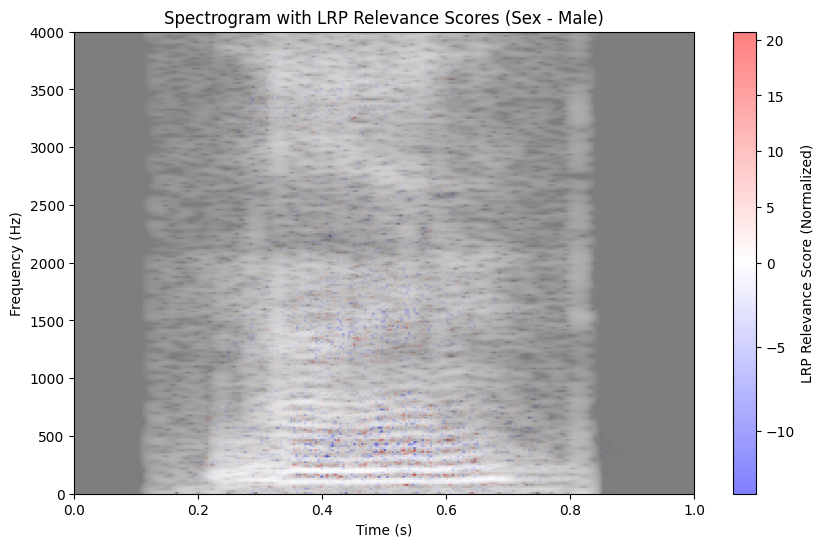

In [29]:
plotSpectrogramWithLRP(test_data_point_np, attributions_np, test_target_point)

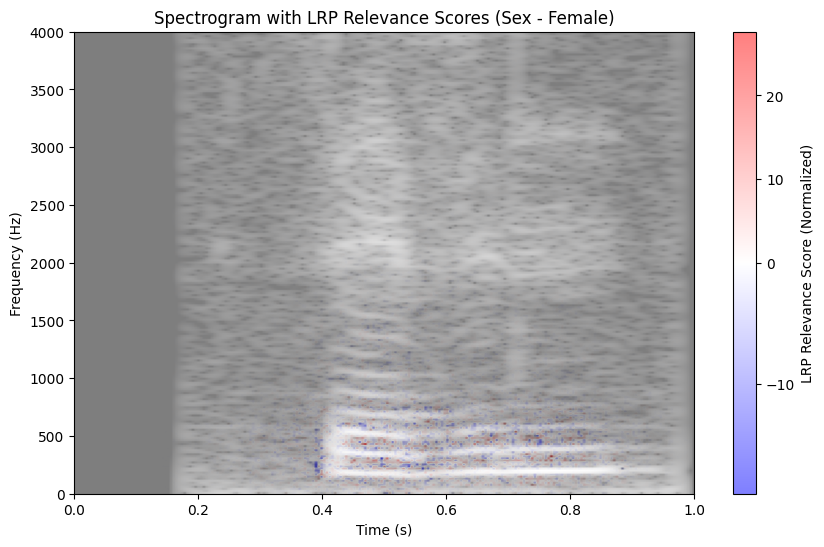

In [30]:
plotSpectrogramWithLRP(test_data_point_np1, attributions_np1, test_target_point1)